# Рубежный контроль №2
## Методы построения моделей машинного обучения. Вариант 12
## Выполнил Плешаков Владислав, РТ5-61Б

Задача: Для заданного набора данных (по Вашему варианту) постройте модели классификации или регрессии (в зависимости от конкретной задачи, рассматриваемой в наборе данных). Для построения моделей используйте методы 1 и 2 (по варианту для Вашей группы). Оцените качество моделей на основе подходящих метрик качества (не менее двух метрик). Какие метрики качества Вы использовали и почему? Какие выводы Вы можете сделать о качестве построенных моделей? Для построения моделей необходимо выполнить требуемую предобработку данных: заполнение пропусков, кодирование категориальных признаков, и т.д.

Датасет: https://www.kaggle.com/datasets/fivethirtyeight/fivethirtyeight-comic-characters-dataset?select=dc-wikia-data.csv

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
import xgboost as xgb
import graphviz
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

In [2]:
data = pd.read_csv('data/dc-wikia-data.csv', sep=',')
data.head()

,page_id,name,urlslug,ID,ALIGN,EYE,HAIR,SEX,GSM,ALIVE,APPEARANCES,FIRST APPEARANCE,YEAR
0,1422,Batman (Bruce Wayne),\/wiki\/Batman_(Bruce_Wayne),Secret Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,NaN,Living Characters,3093.0,"1939, May",1939.0
1,23387,Superman (Clark Kent),\/wiki\/Superman_(Clark_Kent),Secret Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,NaN,Living Characters,2496.0,"1986, October",1986.0
2,1458,Green Lantern (Hal Jordan),\/wiki\/Green_Lantern_(Hal_Jordan),Secret Identity,Good Characters,Brown Eyes,Brown Hair,Male Characters,NaN,Living Characters,1565.0,"1959, October",1959.0
3,1659,James Gordon (New Earth),\/wiki\/James_Gordon_(New_Earth),Public Identity,Good Characters,Brown Eyes,White Hair,Male Characters,NaN,Living Characters,1316.0,"1987, February",1987.0
4,1576,Richard Grayson (New Earth),\/wiki\/Richard_Grayson_(New_Earth),Secret Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,NaN,Living Characters,1237.0,"1940, April",1940.0


In [3]:
# Удаление ненужных колонок
data.drop(columns=['page_id', 'name', 'urlslug'], inplace=True)

In [4]:
data.dtypes

ID                   object
ALIGN                object
EYE                  object
HAIR                 object
SEX                  object
GSM                  object
ALIVE                object
APPEARANCES         float64
FIRST APPEARANCE     object
YEAR                float64
dtype: object

Посмотрим сколько значений пропущено

In [5]:
for col in data.columns:
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0:
        temp_perc = round((temp_null_count / data.shape[0]) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка ID. Тип данных object. Количество пустых значений 2013, 29.19%.
Колонка ALIGN. Тип данных object. Количество пустых значений 601, 8.72%.
Колонка EYE. Тип данных object. Количество пустых значений 3628, 52.61%.
Колонка HAIR. Тип данных object. Количество пустых значений 2274, 32.98%.
Колонка SEX. Тип данных object. Количество пустых значений 125, 1.81%.
Колонка GSM. Тип данных object. Количество пустых значений 6832, 99.07%.
Колонка ALIVE. Тип данных object. Количество пустых значений 3, 0.04%.
Колонка APPEARANCES. Тип данных float64. Количество пустых значений 355, 5.15%.
Колонка FIRST APPEARANCE. Тип данных object. Количество пустых значений 69, 1.0%.
Колонка YEAR. Тип данных float64. Количество пустых значений 69, 1.0%.


Удалим столбцы EYE и GSM из-за большого количества пропусков

In [6]:
data.drop(columns=['EYE', 'GSM', 'YEAR'], inplace=True)

Удалим строки, содержащие пропуски в столбцах YEAR, FIRST APPEARANCE и ALIGN

In [7]:
data.dropna(axis=0, how='any', subset=['FIRST APPEARANCE', 'ALIGN', 'APPEARANCES'], inplace=True)

Заполним пропуски в категориальных столбцах при помощих самых часто встречаемых значений

In [8]:
cat_simp_imp = SimpleImputer(strategy='most_frequent')
cat_data_imputed = cat_simp_imp.fit_transform(data.drop(columns=['APPEARANCES']))
data[data.drop(columns=['APPEARANCES']).columns] = cat_data_imputed
data.isnull().sum()

ID                  0
ALIGN               0
HAIR                0
SEX                 0
ALIVE               0
APPEARANCES         0
FIRST APPEARANCE    0
dtype: int64

Теперь закодируем категориальные признаки

In [9]:
oe = OrdinalEncoder()
attrs_coded = oe.fit_transform(data.drop(columns=['ALIGN', 'APPEARANCES']))
data[data.drop(columns=['ALIGN', 'APPEARANCES']).columns] = attrs_coded

le = LabelEncoder()
target_coded = le.fit_transform(data[['ALIGN']])
data['ALIGN'] = target_coded
le.classes_

D:\Stud\6 term\TMO_BMSTU_22\venv\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array(['Bad Characters', 'Good Characters', 'Neutral Characters',
       'Reformed Criminals'], dtype=object)

## Разделение выборки на обучающую и тестовую

В качестве уелевого признака возьмем столбец ALIGN

In [10]:
data_X = data.drop(columns=['ALIGN'])
data_y = data[['ALIGN']]
train_X, test_X, train_y, test_y = train_test_split(data_X, data_y)

## Дерево решений

In [11]:
tree_params_search = {
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_leaf': [0.04, 0.06, 0.08, 0.1],
    'max_features': [0.2, 0.4, 0.6, 0.8, 1]
}

In [12]:
grid_search_tree = GridSearchCV(DecisionTreeClassifier(), tree_params_search, scoring='accuracy', cv=StratifiedKFold(n_splits=5), n_jobs=4)
grid_search_tree.fit(train_X, train_y)

grid_search_tree.best_params_, grid_search_tree.best_score_

D:\Stud\6 term\TMO_BMSTU_22\venv\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


({'max_depth': 6, 'max_features': 0.8, 'min_samples_leaf': 0.04},
 0.5963507939885894)

0.6009453072248481

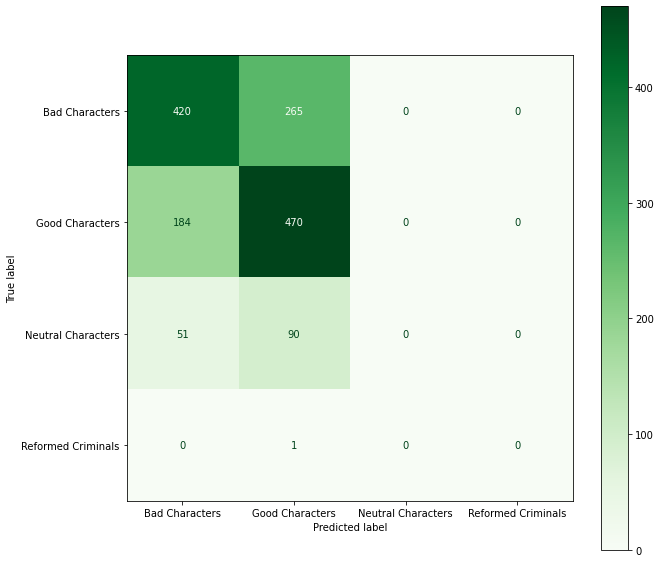

In [13]:
tree: DecisionTreeClassifier = grid_search_tree.best_estimator_
tree.fit(train_X, train_y)
tree_pred = tree.predict(test_X)
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(test_y, tree_pred, ax=ax, cmap='Greens', display_labels=le.classes_)
accuracy_score(tree_pred, test_y)

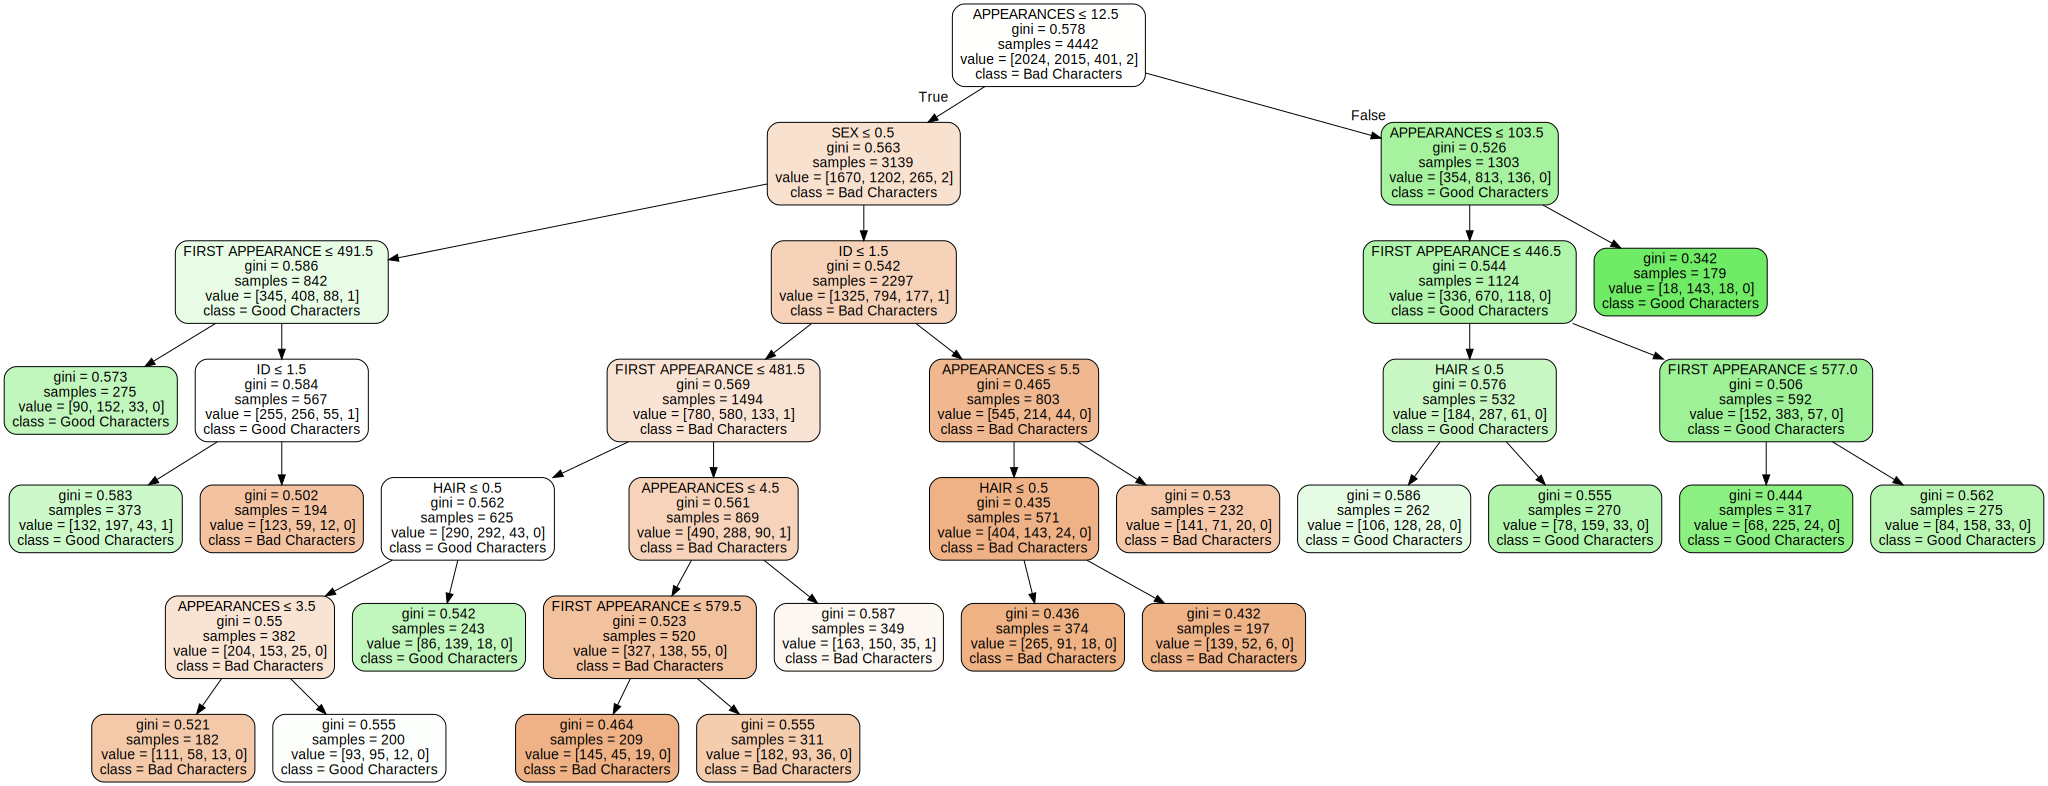

In [14]:
dot_data = export_graphviz(tree, out_file=None,
                           feature_names=list(data_X.columns),
                           class_names=list(le.classes_),
                           filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph

## Градиентный бустинг

In [15]:
xgb_model = xgb.XGBClassifier()
xgb_params = {'learning_rate': [0.01, 0.05, 0.1, 0.12, 0.15, 0.2, 0.3, 0.5, 0.7],
              'max_depth': [5, 6, 7, 8],
              'min_child_weight': [2, 3, 5, 11],
              'n_estimators': [1, 2, 5, 10, 12, 15, 20]}

xgb_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_params, cv=5, n_jobs=4, scoring='accuracy')
xgb_search.fit(train_X, train_y)
xgb_search.best_params_, xgb_search.best_score_

D:\Stud\6 term\TMO_BMSTU_22\venv\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


({'learning_rate': 0.12,
  'max_depth': 7,
  'min_child_weight': 5,
  'n_estimators': 15},
 0.615038660707952)

0.6158001350438893

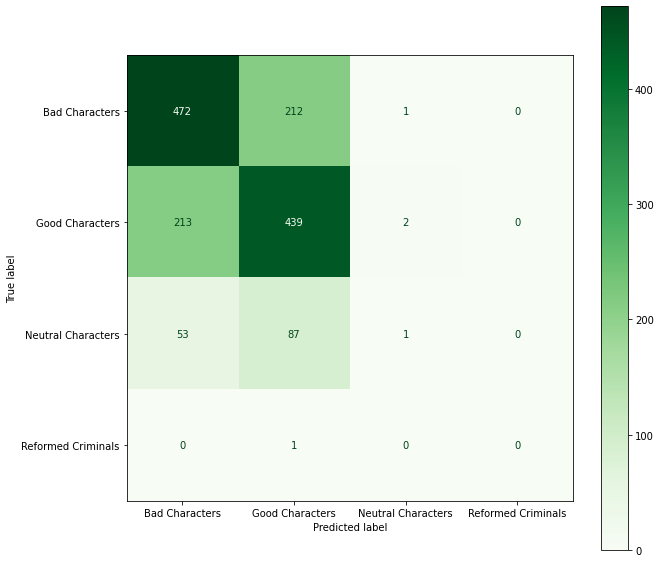

In [16]:
xgb_class: xgb.XGBClassifier = xgb_search.best_estimator_
xgb_class.fit(train_X, train_y)
xgb_pred = xgb_class.predict(test_X)
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(test_y, xgb_pred, ax=ax, cmap='Greens', display_labels=le.classes_)
accuracy_score(xgb_pred, test_y)

Градиентный бустинг получился точнее, чем дерево решений, но при этом все равно ошибается при определении классов Neutral Characters и Reformed Criminals